In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet_uniform import *
from NN_library.AutoUnet.train_AutoUnet import *
from NN_library.VAE.VAE import *
from torch.nn.functional import gumbel_softmax, pad, avg_pool2d
%load_ext autoreload
%autoreload 2

Using device: cuda
Using device: cuda


In [3]:
data = dataset_uniform()
loaders = get_loaders(data, 1)
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev}

In [4]:
name_unet = 'NN_library/AutoUnet/AutoUnet_uniform'
unet = AutoUNet()
unet = load_network(unet, name_unet, args)
unet = unet.to(dev)
for p in unet.parameters():
    p.requires_grad_ = False
unet.eval()

AutoUNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (upconv1): ConvTranspose2d

In [5]:
from NN_library.ConvNet.ConvNet_uniform import *
name_convnet = 'NN_library/ConvNet/ConvNet_uniform'
convnet = ConvNet(16)
convnet = load_network(convnet, name_convnet, args)
convnet = convnet.to(dev)
for p in convnet.parameters():
    p.requires_grad_ = False
convnet.eval()

Using device: cuda


ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (13): ReLU()
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=2, bias=True)
    (2): Sigmoid()
  )
)

In [6]:
geometry, damage, imp_shrinkage, _, _ = data.__getitem__(0)
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])

In [7]:
def circle_fun(x, y, par):
    xc, yc, d = par
    r = d/2
    circle = lambda x, y, xc, yc, r: (x - xc)**2 + (y - yc)**2 - r**2
    z1 = F.softplus(circle(x, y, xc, yc, r)) / 32
    z2 = F.softplus(circle(x-32, y, xc, yc, r)) / 32
    z3 = F.softplus(circle(x, y-32, xc, yc, r)) / 32
    z4 = F.softplus(circle(x-32, y-32, xc, yc, r)) / 32
    z5 = F.softplus(circle(x+32, y, xc, yc, r)) / 32
    z6 = F.softplus(circle(x, y+32, xc, yc, r)) / 32
    z7 = F.softplus(circle(x+32, y+32, xc, yc, r)) / 32
    z = torch.log(z1*z2*z3*z4*z5*z6*z7 + 1.)
    return z / z.max()

In [105]:
def circle_fun_cut(x, y, par):
    xc, yc, d = par
    r = d/2
    circle = lambda x, y, xc, yc, r: (x - xc)**2 + (y - yc)**2 - r**2
    z1 = torch.relu(circle(x, y, xc, yc, r)) / 32
    z2 = torch.relu(circle(x-32, y, xc, yc, r)) / 32
    z3 = torch.relu(circle(x, y-32, xc, yc, r)) / 32
    z4 = torch.relu(circle(x-32, y-32, xc, yc, r)) / 32
    z5 = torch.relu(circle(x+32, y, xc, yc, r)) / 32
    z6 = torch.relu(circle(x, y+32, xc, yc, r)) / 32
    z7 = torch.relu(circle(x+32, y+32, xc, yc, r)) / 32
    z = torch.clamp(z1*z2*z3*z4*z5*z6*z7, max=1.)
    return z

In [8]:
def add_interface(geometry_bw):
    geometry_ud = geometry_bw[:,1:] - geometry_bw[:,:-1]
    geometry_diff = torch.zeros_like(geometry, device=dev)
    geometry_diff[:,:-1] += torch.where(geometry_ud==1., 1., 0.)
    geometry_diff[:,1:] += torch.where(geometry_ud==-1., 1., 0.)
    geometry_bw1 = geometry_bw + geometry_diff
    geometry_lr = geometry_bw1[:,:,1:] - geometry_bw1[:,:,:-1]
    geometry_diff[:,:,:-1] += torch.where(geometry_lr==1., 1., 0.)
    geometry_diff[:,:,1:] += torch.where(geometry_lr==-1., 1., 0.)
    geometry_diff = torch.where(geometry_diff>0., 1., 0.)
    return geometry_bw+0.5*geometry_diff

In [9]:
dist = torch.linspace(0, 32, 100)[:-1]
x, y = torch.meshgrid([dist, dist])
xy = torch.stack([x, y], dim=0)
xy = xy.to(dev)

c:\Users\Jorge\.conda\envs\home\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [99]:
def rc_to_img(rc):
    zs = []
    for i in range(rc.shape[0]):
        zs.append(circle_fun(xy[0], xy[1], rc[0]))
    z = zs[0]
    for i in range(1, rc.shape[0]):
        z *= circle_fun_cut(xy[0], xy[1], rc[i])
    logit = torch.stack([100*z, 100*(1-z)]) 
    geometry_bw = gumbel_softmax(logit, hard=True, dim=0)[0]
    geometry = add_interface(geometry_bw.unsqueeze(0))
    return geometry

In [11]:
def cost_function(damage, geometry, volume):
    new_volume = torch.where(geometry==1., 1., 0.).sum() / 99**2
    total_damage = damage.sum() / 99**2
    penalty = 10 * (new_volume - volume)**2
    cost = total_damage + penalty
    return cost, total_damage.item(), penalty.item()

In [12]:
def cost_function_shrinkage(damage, geometry, volume):
    new_volume = torch.where(geometry==1., 1., 0.).sum() / 99**2
    total_shr = damage[:,0].sum()
    penalty = 10 * (new_volume - volume)**2
    cost = total_shr - penalty
    return cost, total_shr.item(), penalty.item()

In [91]:
rc_sin = torch.tensor([[0., 0., torch.pi], [torch.pi/2, torch.pi/2, torch.pi]])
rc =  torch.sin(rc_sin)
rc[:, :2] = 16 * (1 + rc[:,:2])
rc[:, 2] = 8 * (1 + rc[:,2])

In [92]:
rc

tensor([[16.0000, 16.0000,  8.0000],
        [32.0000, 32.0000,  8.0000]])

In [93]:
z1 = circle_fun_cut(xy[0], xy[1], rc[0])
z2 = circle_fun_cut(xy[0], xy[1], rc[1])
z =  z1*z2
logit = torch.stack([10*z, 10*(1-z)]) 
geometry_bw = gumbel_softmax(logit, hard=True, dim=0)

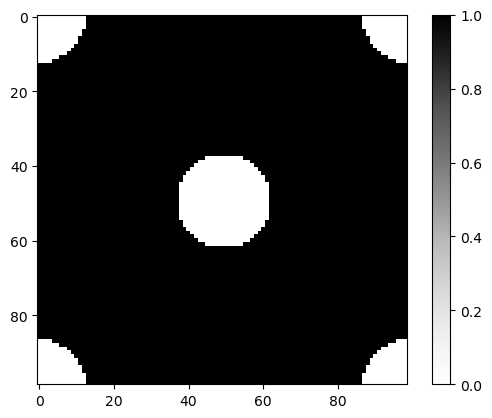

In [94]:
plt.imshow(z.detach().cpu(), cmap='Greys')
plt.colorbar()

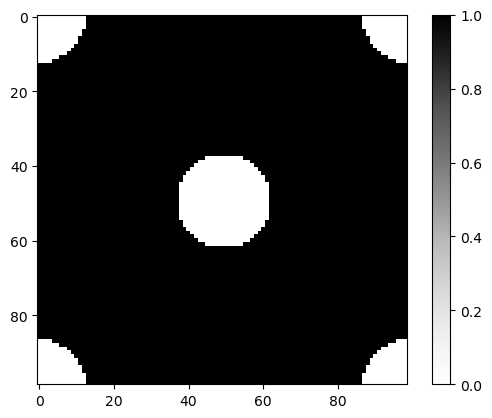

In [95]:
plt.imshow(geometry_bw[0].cpu(), cmap='Greys')
plt.colorbar()

# Shrinkage optimization

In [192]:
# starting point
#rc_sin = torch.tensor([[0., 0., 4.5*torch.pi/4], [5*torch.pi/4, 5*torch.pi/4, 4.5*torch.pi/4], [torch.pi/4, torch.pi/4, 4.5*torch.pi/4]], device=dev)
rc_sin = 2 * torch.pi * torch.rand((12, 3), device=dev)
rc_sin.requires_grad_()

optimizer = optim.Adam([rc_sin], lr = 0.001, maximize=False)

rc =  torch.sin(rc_sin)
rc[:, :2] = 16 * (1 + rc[:, :2])
rc[:2, 2] = 8 * (1 + rc[:2, 2])
rc[2:6, 2] = 4 * (1 + rc[2:6, 2])
rc[6:, 2] = 2 * (1 + rc[6:, 2])
geometry = rc_to_img(rc)

start = geometry.clone().detach()
volume = (torch.where(geometry==1., 1., 0.).sum() / 99**2).detach()
costs = []
damages = []
penalties = []

In [193]:
rc

tensor([[2.1592e+01, 1.9557e+01, 1.1385e+01],
        [3.1361e+01, 2.8033e+01, 1.1141e+01],
        [2.5264e+01, 7.8191e+00, 4.8860e+00],
        [3.5356e+00, 1.2356e+01, 7.7761e+00],
        [5.4615e-02, 8.1717e+00, 1.8200e-01],
        [1.9086e+01, 2.8162e-03, 3.7428e+00],
        [1.7218e+01, 1.2779e-01, 3.1901e-01],
        [2.5437e+00, 6.4641e+00, 2.1271e+00],
        [1.7301e+01, 2.9987e+01, 8.5833e-01],
        [2.5319e+01, 3.0805e+01, 4.3917e-04],
        [3.1857e+01, 7.2968e-01, 2.0415e+00],
        [2.6974e+01, 2.6030e+01, 1.3533e+00]], device='cuda:0',
       grad_fn=<CopySlices>)

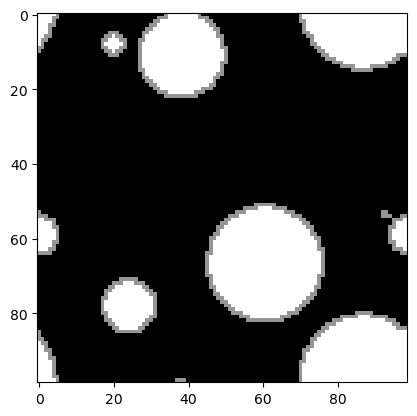

In [194]:
plt.imshow(start[0].cpu(), cmap='Greys', vmin=0, vmax=1)

In [200]:
for i in range(1000, 2000):
    rc =  torch.sin(rc_sin)
    rc[:, :2] = 16 * (1 + rc[:, :2])
    rc[:2, 2] = 8 * (1 + rc[:2, 2])
    rc[2:6, 2] = 4 * (1 + rc[2:6, 2])
    rc[6:, 2] = 2 * (1 + rc[6:, 2])
    new_geometry = rc_to_img(rc)
    for n in range(10):
        if n == 0:
            x = torch.cat([new_geometry, imp_shrinkage[[1],:,:] / -0.001, damage[[0],:,:]], axis=0)
        else:
            x = torch.cat([new_geometry, imp_shrinkage[[n+1],:,:] / -0.001, y[0]], axis=0)
        y = unet(x.unsqueeze(0))
    #x_shr = torch.cat([new_geometry, imp_shrinkage[[-1],:,:] / -0.001, y[0]], axis=0)
    #shrinkage = convnet(x_shr.unsqueeze(0))
    if i == 0:
        start_damage = y.clone().detach()
    #cost, d, p = cost_function_shrinkage(shrinkage, new_geometry, volume)
    cost, d, p = cost_function(y, new_geometry, volume)
    # Optimizer step
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    costs.append(cost.item())
    damages.append(d)
    penalties.append(p)

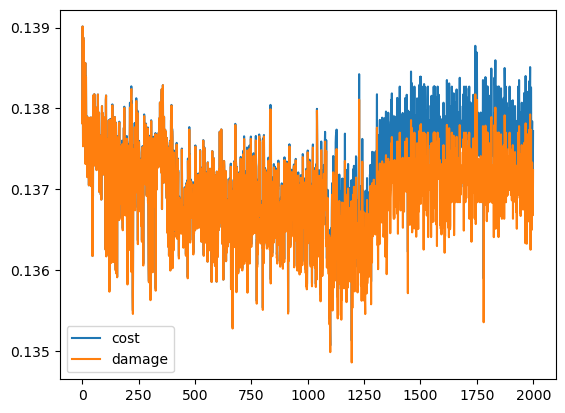

In [204]:
plt.plot(costs)
plt.plot(damages)
#plt.plot(penalties)
plt.legend(['cost', 'damage', 'penalty'])

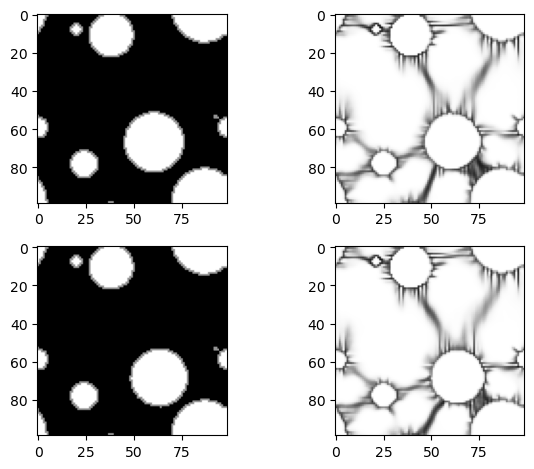

In [202]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(start[0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[0, 1].imshow(start_damage[0,0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 0].imshow(new_geometry[0].detach().cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 1].imshow(y[0,0].detach().cpu(),  cmap='Greys', vmin=0, vmax=1)
plt.tight_layout() 